# Chicago L Ridership

This Jupyter Notebook analyzes the ridership of the Chicago e"L"evated public transportation system. Ridership numbers come from Chicago's open data portal, found here: https://data.cityofchicago.org/Transportation/CTA-Ridership-L-Station-Entries-Daily-Totals/5neh-572f

In [31]:
# Import pandas for our data analysis and matplotlib for our plotting
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

The questions of interest are: 

1. Which stop has the highest average ridership per day, and what is it?
2. Which stop has the greatest standard deviation in weekday (exclude holidays) ridership per day, and what is it?

I will go about this by importing the data into a pandas DataFrame, getting a feel for what the data can tell me about ridership numbers, then grouping the ridership numbers by weekday while finding a resource that lists holiday days and week days for the last 16 years.

In [32]:
ridership = pd.read_json('https://data.cityofchicago.org/resource/mh5w-x5kh.json')
print(ridership.head())
print(ridership.shape)

                 date daytype  rides  station_id    stationname
0 2016-11-24 18:00:00       W    905       41010       Rockwell
1 2016-11-20 18:00:00       W   3538       41340        LaSalle
2 2016-11-14 18:00:00       W   5095       41380      Bryn Mawr
3 2016-11-08 18:00:00       W  16620       41450  Chicago/State
4 2016-11-25 18:00:00       A   3130       40560  Jackson/State
(1000, 5)


I'm not getting the full dataset this way. I think I need an AppToken to access the full dataset. Let's just download the json format to our local drive.

In [33]:
ridership = pd.read_csv('ridership.csv')
print(ridership.head())
print(ridership.shape)

   station_id         stationname        date daytype  rides
0       40010  Austin-Forest Park  01/01/2001       U    290
1       40020         Harlem-Lake  01/01/2001       U    633
2       40030        Pulaski-Lake  01/01/2001       U    483
3       40040        Quincy/Wells  01/01/2001       U    374
4       40050               Davis  01/01/2001       U    804
(826894, 5)


Now let's try to answer the question. Which station has the highest average ridership?

In [34]:
mean_ridership = ridership.groupby(by='stationname')['rides'].mean()
mean_ridership.sort_values(ascending=False, inplace=True)
mean_ridership.head()

stationname
Clark/Lake            13661.190402
Lake/State            13299.597592
Chicago/State         12944.953208
95th/Dan Ryan         10859.289046
Belmont-North Main    10440.290384
Name: rides, dtype: float64

Over the entire window, it looks like Clark/Lake had the highest mean ridership, averaging nearly 14,000 riders per day!

In [35]:
# Sanity check
ridership[ridership['stationname'] == 'Clark/Lake'].mean()

station_id    40380.000000
rides         13661.190402
dtype: float64

That's more like it. Now, the API Docs give us the following useful information:

>This list shows daily totals of ridership, by station entry, for each 'L' station dating back to 2001. Dataset shows entries at all turnstiles, combined, for each station. Daytypes are as follows: W=Weekday, A=Saturday, U=Sunday/Holiday. See attached readme file for information on how these numbers are calculated.

>From https://dev.socrata.com/foundry/data.cityofchicago.org/mh5w-x5kh
    
So now we know that it should be easy enough for us to sort through the day for the second question. 

/home/chris/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=14).mean()
/home/chris/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


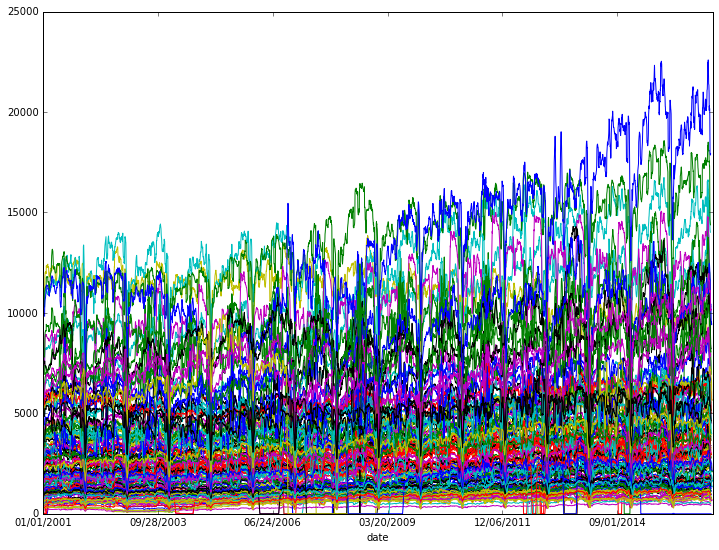

(0.0, 5832.0)

In [53]:
# Use groupby to get the data associated with each individual station
by_station = ridership.groupby(by='stationname')


# Get a useless but visually cool timeseries plot to get a feel for the data
fh = plt.figure(figsize=(12,9))
ax = fh.add_subplot(111)
for station, df in by_station:
    df['rides'] = pd.rolling_mean(df['rides'], 14)
    df.plot(x='date', y='rides', ax=ax, label=station, legend=False, style={'linestyle':'None', 'marker': '.'})

daterange = plt.xlim()
plt.show()
daterange